In [134]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import re
import os
import ast

### SPARK

In [135]:
!pip install geopandas
!pip install osmnx geopandas
!pip install scipy scikit-learn
!pip install pyspark
!pip install pyarrow
!pip install matplotlib
!pip install seaborn	

In [136]:
import geopandas as gpd
import pandas as pd

# Vérifier si le fichier existe déjà
output_file = 'data_coord/clusters-rouges.csv'
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
    df_clusters = pd.read_csv(output_file)
    print(f"  {len(df_clusters)} lignes chargées")
    display(df_clusters.head())
else:
    print(f"Création du fichier '{output_file}'...")
    # Lire le fichier GeoJSON
    gdf_clusters = gpd.read_file('data_coord/clusters-rouges-200046977.geojson')

    # Extraire les propriétés et coordonnées du centroid
    df_clusters = pd.DataFrame(gdf_clusters.drop(columns='geometry'))
    df_clusters['longitude'] = gdf_clusters.geometry.centroid.x
    df_clusters['latitude'] = gdf_clusters.geometry.centroid.y

    # Exporter en CSV
    df_clusters.to_csv(output_file, index=False)
    print(f"Fichier '{output_file}' créé avec {len(df_clusters)} lignes")
    display(df_clusters.head())

✓ Le fichier 'data_coord/clusters-rouges.csv' existe déjà, chargement...
  164 lignes chargées


,uid,insee,cat,nb_points,taux_points,longitude,latitude
0,1928af76-3a27-4bb5-82bb-008f4b9b3e86,69199,58,24,64.86,4.854812,45.716985
1,1eca17ef-9918-4bf9-8538-6483192bcd51,69266,58,179,8.69,4.905975,45.769277
2,0b7b0a92-d58f-4977-a3eb-8a3fee9c15ba,69266,58,286,13.88,4.882567,45.768935
3,7344fd97-e04c-4f58-94e1-3f9be8129a90,69388,58,78,17.45,4.860312,45.749487
4,04b1ae46-0b6b-4e2f-b5a5-b97055ce0b37,69081,58,228,131.79,4.793206,45.773931


In [137]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

output_file = 'data_coord/clusters-rouges.csv'
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
else :
    # Charger le réseau routier de Lyon
    G = ox.graph_from_place("Lyon, France", network_type="drive")

    # Projeter le graphe en mètres (UTM) pour un calcul de distance précis
    G_proj = ox.project_graph(G)

    # Préparer les données - convertir en centroids pour avoir des Points
    gdf_proj = gdf_clusters.to_crs(G_proj.graph['crs'])
    centroids_proj = gdf_proj.geometry.centroid

    # Trouver l'arête (rue) la plus proche pour chaque centroid
    nearest_edges = ox.nearest_edges(G_proj, X=centroids_proj.x, Y=centroids_proj.y)

    # Calculer le point exact sur la rue (projection orthogonale)
    edges = ox.graph_to_gdfs(G_proj, nodes=False)
    projected_points = []

    for i, (centroid, edge_id) in enumerate(zip(centroids_proj, nearest_edges)):
        # Récupérer la ligne (geometry) de la rue correspondante
        street_line = edges.loc[edge_id, 'geometry']
        # Trouver le point sur cette ligne le plus proche du centroid
        snap_point = street_line.interpolate(street_line.project(centroid))
        projected_points.append(snap_point)

    # Créer un GeoDataFrame temporaire pour convertir les points projetés en Lat/Lon
    snapped_gdf = gpd.GeoDataFrame(geometry=projected_points, crs=G_proj.graph['crs'])
    snapped_gdf = snapped_gdf.to_crs(epsg=4326)

    # Ajouter les colonnes au DataFrame d'origine
    gdf_clusters['longitude_modified'] = snapped_gdf.geometry.x
    gdf_clusters['latitude_modified'] = snapped_gdf.geometry.y

    # Affichage des résultats
    display(gdf_clusters[['longitude_modified', 'latitude_modified']].head())

✓ Le fichier 'data_coord/clusters-rouges.csv' existe déjà, chargement...


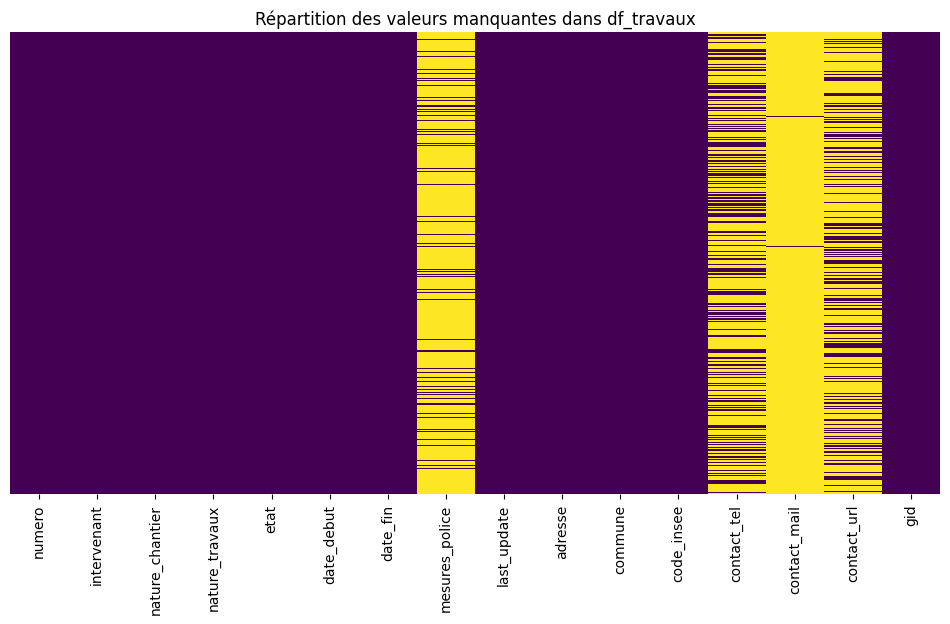

In [138]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
# Charger le dataframe du dataset des travaux engagés à Lyon
df_travaux = pd.read_csv("data_travaux/travaux-engages-metropole-lyon.csv", sep=";")
# Visualisation des valeurs manquantes dans df_travaux
plt.figure(figsize=(12, 6))
sns.heatmap(df_travaux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_travaux')
plt.show()

In [139]:
cols_travaux_a_supprimer = ['mesures_police', 'contact_tel', 'contact_mail', 'contact_url'] # Trop de NaN dans les colonnes
df_travaux = df_travaux.drop(columns=cols_travaux_a_supprimer, errors='ignore')

In [140]:
print("--- Valeurs manquantes dans df_travaux ---")
print(df_travaux.isnull().sum())

# Supprime les lignes où 'date_debut' est NaN
df_travaux = df_travaux.dropna(subset=['date_debut'])

--- Valeurs manquantes dans df_travaux ---
numero             0
intervenant        0
nature_chantier    0
nature_travaux     0
etat               0
date_debut         3
date_fin           0
last_update        0
adresse            0
commune            0
code_insee         0
gid                0
dtype: int64


In [141]:
df_flux = pd.read_csv("data_flux/mesures-comptage-metropole-lyon.csv", sep=';')


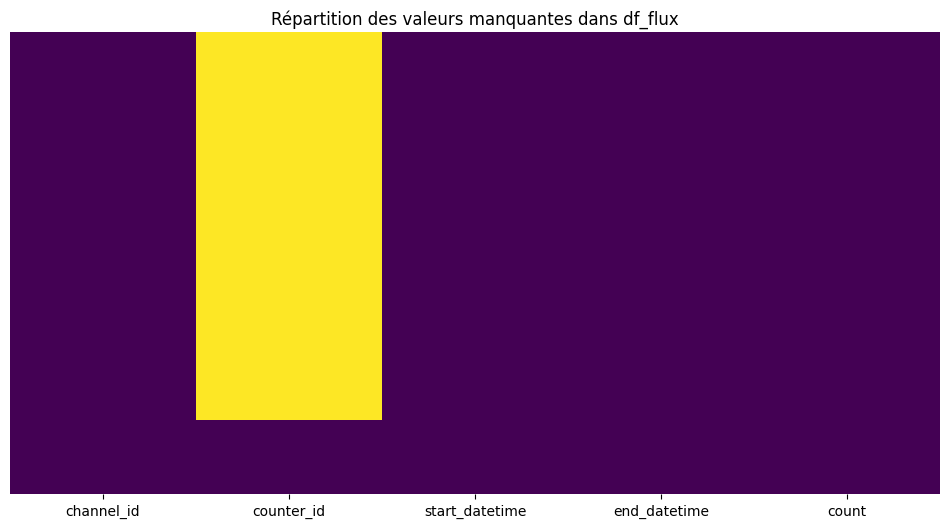

In [142]:
# Visualisation des valeurs manquantes dans df_flux
plt.figure(figsize=(12, 6))
sns.heatmap(df_flux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_flux')
plt.show()

In [143]:
# Suppression de la colonne 'counter_id' 
df_flux = df_flux.drop(columns="counter_id", errors='ignore')

In [144]:
# Charger les données de flux détaillées
df_mesure_flux = pd.read_csv("data_flux/mesure_flux.csv", sep=';')

# Suppression de la colonne 'counter_id' et filtrage des valeurs > 0
df_mesure_flux = df_mesure_flux.drop(columns="counter_id", errors='ignore')
df_mesure_flux = df_mesure_flux[df_mesure_flux['count'] > 0]

print(f"Données de mesure flux: {len(df_mesure_flux)} lignes")
display(df_mesure_flux.head())

Données de mesure flux: 864 lignes


,channel_id,start_datetime,end_datetime,count
3,100029813,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,1
5,100029813,2023-04-05 20:00:00+02:00,2023-04-05 21:00:00+02:00,6
6,100029813,2023-04-05 19:00:00+02:00,2023-04-05 20:00:00+02:00,37
7,100029813,2023-04-05 18:00:00+02:00,2023-04-05 19:00:00+02:00,80
8,100029813,2023-04-05 17:00:00+02:00,2023-04-05 18:00:00+02:00,90


In [145]:
import pandas as pd
import geopandas as gpd

# Chargement des référentiels
df_channels_flux = pd.read_csv("./data_flux/channels_flux.csv", sep=";")
df_channels_flux = df_channels_flux[df_channels_flux['mobility_type'] == 'BIKE']
gdf_sites_flux = gpd.read_file("./data_flux/sites_flux.json")

# Harmonisation des types
df_mesure_flux['channel_id'] = df_mesure_flux['channel_id'].astype(str)
df_channels_flux['channel_id'] = df_channels_flux['channel_id'].astype(str)
df_channels_flux['site_id'] = df_channels_flux['site_id'].astype(str)
gdf_sites_flux['site_id'] = gdf_sites_flux['site_id'].astype(str)

# Fusion des données
df_intermediaire = pd.merge(
    df_mesure_flux, 
    df_channels_flux[['channel_id', 'site_id']], 
    on='channel_id', 
    how='inner'
)

gdf_final = gdf_sites_flux.merge(df_intermediaire, on='site_id', how='inner')

print(f"Fusion réussie ! Nombre de lignes finales : {len(gdf_final)}")
display(gdf_final.head())

Fusion réussie ! Nombre de lignes finales : 756


,id,gid,site_id,parent_site_id,fr_insee_code,xlong,ylat,external_ids,infrastructure_type,site_name,geometry,channel_id,start_datetime,end_datetime,count
0,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,2
1,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,6
2,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,21
3,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,18
4,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,28


In [146]:
# Sélection des colonnes essentielles
colonnes_a_garder = [
    'geometry', 
    'site_name', 
    'count', 
    'start_datetime', 
    'end_datetime'
]

gdf_final_clean = gdf_final[colonnes_a_garder].copy()

# Formater les dates
gdf_final_clean['start_datetime'] = pd.to_datetime(gdf_final_clean['start_datetime'])
gdf_final_clean['end_datetime'] = pd.to_datetime(gdf_final_clean['end_datetime'])

print("Dataset final optimisé :")
display(gdf_final_clean.head())

Dataset final optimisé :


,geometry,site_name,count,start_datetime,end_datetime
0,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,2,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00
1,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,6,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00
2,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,21,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00
3,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,18,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00
4,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,28,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00


In [147]:
# Vérifier si le fichier existe déjà
output_file = "data_flux_final/comptages_flux.csv"
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, skip de la génération.")
else:
    print(f"Création du fichier '{output_file}'...")
    # Extraire latitude et longitude de la géométrie
    gdf_final_clean['longitude'] = gdf_final_clean.geometry.x
    gdf_final_clean['latitude'] = gdf_final_clean.geometry.y

    # Exporter en CSV
    gdf_final_clean.drop(columns=['geometry']).to_csv(output_file, index=False, sep=";")
    print(f"Le fichier '{output_file}' a été généré avec succès.")

✓ Le fichier 'data_flux_final/comptages_flux.csv' existe déjà, skip de la génération.


In [148]:
import pandas as pd
import requests
import os

# Vérifier si le fichier existe déjà
output_file = "data_flux_final/comptages_villeavelo_final.csv"
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
    df_final_villeavelo = pd.read_csv(output_file, sep=";")
    print(f"  {len(df_final_villeavelo)} lignes chargées")
    display(df_final_villeavelo.head())
else:
    print(f"Création du fichier '{output_file}'...")
    
    # Chargement des données villeavelo
    df_villavelo = pd.read_csv("./data_flux/comptage_villeavelo.csv", sep=";")

    # Nettoyer les NaN dans les colonnes importantes
    df_villavelo = df_villavelo.dropna(subset=['Adresse', 'Date', 'Heure début', 'Heure fin', 'Nombre comptés'])

    def geocode_adresse(adresse):
        """Interroge l'API Adresse du gouvernement français."""
        url = "https://api-adresse.data.gouv.fr/search/"
        params = {'q': f"{adresse}, Lyon", 'limit': 1}
        try:
            response = requests.get(url, params=params, timeout=5)
            data = response.json()
            if data['features']:
                lon, lat = data['features'][0]['geometry']['coordinates']
                return lat, lon
        except Exception as e:
            print(f"Erreur pour l'adresse {adresse}: {e}")
        return None, None

    # Géocodage
    print(f"Géocodage en cours pour {len(df_villavelo)} adresses...")
    coords = df_villavelo['Adresse'].apply(geocode_adresse)
    df_villavelo[['latitude', 'longitude']] = pd.DataFrame(coords.tolist(), index=df_villavelo.index)

    # Transformation au format final
    df_final_villeavelo = pd.DataFrame()
    df_final_villeavelo['Adresse'] = df_villavelo['Adresse']
    df_final_villeavelo['count'] = df_villavelo['Nombre comptés']

    # Conversion des dates avec gestion d'erreur
    try:
        df_final_villeavelo['start_datetime'] = pd.to_datetime(
            df_villavelo['Date'] + ' ' + df_villavelo['Heure début'], 
            dayfirst=True,
            errors='coerce'
        )
        df_final_villeavelo['end_datetime'] = pd.to_datetime(
            df_villavelo['Date'] + ' ' + df_villavelo['Heure fin'], 
            dayfirst=True,
            errors='coerce'
        )
    except Exception as e:
        print(f"Erreur lors de la conversion des dates: {e}")

    df_final_villeavelo['longitude'] = df_villavelo['longitude']
    df_final_villeavelo['latitude'] = df_villavelo['latitude']

    # Nettoyage final
    df_final_villeavelo = df_final_villeavelo.dropna(subset=['latitude', 'start_datetime', 'end_datetime'])

    # Exporter df_final_villeavelo en CSV
    df_final_villeavelo.to_csv(output_file, index=False, sep=";")
    print(f"Traitement villeavelo terminé: {len(df_final_villeavelo)} lignes valides")
    print(f"Fichier '{output_file}' créé avec succès")
    print(f"Colonnes: {list(df_final_villeavelo.columns)}")
    display(df_final_villeavelo.head())

✓ Le fichier 'data_flux_final/comptages_villeavelo_final.csv' existe déjà, chargement...
  1766 lignes chargées


,Adresse,count,start_datetime,end_datetime,longitude,latitude
0,Avenue des Cottages,135.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
1,Avenue des Cottages,7.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
2,Avenue des Cottages,25.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
3,Avenue des Cottages,5.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
4,Avenue des Cottages,43.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262


# Priorisation des Problèmes selon les Flux de Passage

**Objectif:** Créer une échelle d'importance des problèmes basée sur les flux cyclables.

**Logique:**
- Problème avec **flux élevé** = Priorité HAUTE (impact sur beaucoup de cyclistes)
- Problème avec **flux moyen** = Priorité MOYENNE
- Problème avec **flux faible** = Priorité BASSE

In [149]:
# Chargement des incidents catégorisés
incidents = pd.read_csv('resultats_croisement_complet/points_rouges_sans_travaux_traite.csv', encoding='utf-8-sig')
print(f"Incidents catégorisés chargés: {len(incidents)} lignes")
print(f"Colonnes: {list(incidents.columns)}")
incidents.head()

Incidents catégorisés chargés: 14853 lignes
Colonnes: ['longitude', 'latitude', 'commune_insee', 'description', 'categories_detectees', 'liste_urgence', 'liste_facilite']


,longitude,latitude,commune_insee,description,categories_detectees,liste_urgence,liste_facilite
0,4.797329,45.803997,69194,Éboulement,['Danger & Vitesse'],[3],[2]
1,4.863795,45.763640,69123,Transformation de la piste cyclable adjointe à...,"['Infrastructure manquante', 'Carrefours dange...","[3, 3, 2, 2]","[3, 3, 2, 2]"
2,4.865337,45.766322,69123,discontinuité des aménagements cyclables côté ...,['Infrastructure manquante'],[3],[3]
3,4.875573,45.769985,69266,marquages au sol d'une piste cyclable mais dan...,"['Infrastructure manquante', 'Conflit Voiture/...","[3, 2, 1]","[3, 2, 1]"
4,4.875320,45.771938,69266,les voitures prennent l'axe Francis de Pressen...,['Conflit Voiture/Stationnement'],[2],[2]


In [150]:
# Chargement des flux officiels
flux_officiels = pd.read_csv('data_flux_final/comptages_flux.csv', sep=';')
print(f"Flux officiels: {len(flux_officiels)} lignes")

# Chargement des flux participatifs VillaVelo
flux_villeavelo = pd.read_csv('data_flux_final/comptages_villeavelo_final.csv', sep=';')
print(f"Flux VillaVelo: {len(flux_villeavelo)} lignes")

flux_officiels.head()

Flux officiels: 756 lignes
Flux VillaVelo: 1766 lignes


,site_name,count,start_datetime,end_datetime,longitude,latitude
0,Lyon 7_Pont Raymond Barre,2,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,4.821243,45.732002
1,Lyon 7_Pont Raymond Barre,6,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,4.821243,45.732002
2,Lyon 7_Pont Raymond Barre,21,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,4.821243,45.732002
3,Lyon 7_Pont Raymond Barre,18,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,4.821243,45.732002
4,Lyon 7_Pont Raymond Barre,28,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,4.821243,45.732002


## 1. Agrégation des Flux par Position Géographique

In [151]:
# Agrégation flux officiels : somme des comptages par site
flux_officiels_agg = flux_officiels.groupby(['site_name', 'longitude', 'latitude']).agg({
    'count': 'sum'
}).reset_index()
flux_officiels_agg.rename(columns={'site_name': 'location', 'count': 'total_flux'}, inplace=True)

print(f"Flux officiels agrégés: {len(flux_officiels_agg)} sites uniques")
print(f"Flux total officiel: {flux_officiels_agg['total_flux'].sum():,.0f} passages")
flux_officiels_agg.head()

Flux officiels agrégés: 6 sites uniques
Flux total officiel: 32,228 passages


,location,longitude,latitude,total_flux
0,Lyon 1_Pont la Feuillée EO corrigé,4.830009,45.766740,11800
1,Lyon 1_Pont la Feuillée OE corrigé,4.830000,45.766754,8273
2,Lyon 7_Pont Raymond Barre,4.821243,45.732002,8884
3,Lyon 7_Pont de l'Université EO corrigé,4.836061,45.752243,1354
4,Lyon 7_Pont de l'Université OE corrigé,4.836061,45.752243,1905


In [152]:
# Agrégation flux participatifs : somme des comptages par adresse
flux_villeavelo_agg = flux_villeavelo.groupby(['Adresse', 'longitude', 'latitude']).agg({
    'count': 'sum'
}).reset_index()
flux_villeavelo_agg.rename(columns={'Adresse': 'location', 'count': 'total_flux'}, inplace=True)

print(f"Flux VillaVelo agrégés: {len(flux_villeavelo_agg)} adresses uniques")
print(f"Flux total VillaVelo: {flux_villeavelo_agg['total_flux'].sum():,.0f} passages")
flux_villeavelo_agg.head()

Flux VillaVelo agrégés: 18 adresses uniques
Flux total VillaVelo: 22,553 passages


,location,longitude,latitude,total_flux
0,Avenue des Cottages,2.811628,48.377262,522.0
1,Bas Montée Bonnafous,4.837716,45.774843,59.0
2,Bas Montée St Sébastien,4.835058,45.772192,1463.0
3,Bas Montée des Forts,4.832572,45.793637,319.0
4,Bvd des Canuts,4.828003,45.778990,4620.0


In [153]:
# Fusion des deux sources de flux
flux_total = pd.concat([flux_officiels_agg, flux_villeavelo_agg], ignore_index=True)

print(f"Flux total combiné: {len(flux_total)} points de comptage")
print(f"Flux cumulé: {flux_total['total_flux'].sum():,.0f} passages")
print(f"\nStatistiques des flux:")
print(flux_total['total_flux'].describe())

Flux total combiné: 24 points de comptage
Flux cumulé: 54,781 passages

Statistiques des flux:
count       24.000000
mean      2282.541667
std       3227.422231
min         12.000000
25%        196.000000
50%       1050.500000
75%       2126.500000
max      11800.000000
Name: total_flux, dtype: float64


## 2. Fonction de Distance Haversine

Calcule la distance entre deux points GPS (en mètres)

In [154]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en mètres entre deux points GPS.
    """
    R = 6371000  # Rayon de la Terre en mètres
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

# Test de la fonction
test_dist = haversine_distance(45.75, 4.85, 45.76, 4.86)
print(f"Distance test (45.75,4.85) -> (45.76,4.86): {test_dist:.0f} mètres")

Distance test (45.75,4.85) -> (45.76,4.86): 1356 mètres


## 3. Croisement Spatial: Trouver le Flux le Plus Proche

Pour chaque incident, on cherche le point de comptage le plus proche et on récupère son flux.

In [155]:
def find_nearest_flux(incident_lat, incident_lon, flux_df):
    """
    Trouve le point de flux le plus proche d'un incident.
    Retourne: (distance_min, flux_total, location)
    """
    distances = []
    
    for idx, row in flux_df.iterrows():
        dist = haversine_distance(
            incident_lat, incident_lon,
            row['latitude'], row['longitude']
        )
        distances.append((dist, row['total_flux'], row['location']))
    
    # Trouver le minimum
    min_dist, flux, location = min(distances, key=lambda x: x[0])
    return min_dist, flux, location

print("Fonction de recherche du flux le plus proche créée.")

Fonction de recherche du flux le plus proche créée.


In [156]:
# Application du croisement spatial sur tous les incidents
print("Croisement en cours... (peut prendre quelques minutes)")

resultats = []
for idx, incident in incidents.iterrows():
    if idx % 100 == 0:
        print(f"Traitement: {idx}/{len(incidents)}...")
    
    dist, flux, location = find_nearest_flux(
        incident['latitude'], 
        incident['longitude'], 
        flux_total
    )
    
    resultats.append({
        'distance_flux_m': dist,
        'flux_proche': flux,
        'location_flux': location
    })

# Ajout des colonnes au DataFrame
resultats_df = pd.DataFrame(resultats)
incidents_flux = pd.concat([incidents, resultats_df], axis=1)

print(f"\nCroisement terminé!")
print(f"Distance moyenne au point de flux: {incidents_flux['distance_flux_m'].mean():.0f} m")
print(f"Distance médiane: {incidents_flux['distance_flux_m'].median():.0f} m")
incidents_flux.head()

Croisement en cours... (peut prendre quelques minutes)
Traitement: 0/14853...
Traitement: 100/14853...
Traitement: 200/14853...
Traitement: 300/14853...
Traitement: 400/14853...
Traitement: 500/14853...
Traitement: 600/14853...
Traitement: 700/14853...
Traitement: 800/14853...
Traitement: 900/14853...
Traitement: 1000/14853...
Traitement: 1100/14853...
Traitement: 1200/14853...
Traitement: 1300/14853...
Traitement: 1400/14853...
Traitement: 1500/14853...
Traitement: 1600/14853...
Traitement: 1700/14853...
Traitement: 1800/14853...
Traitement: 1900/14853...
Traitement: 2000/14853...
Traitement: 2100/14853...
Traitement: 2200/14853...
Traitement: 2300/14853...
Traitement: 2400/14853...
Traitement: 2500/14853...
Traitement: 2600/14853...
Traitement: 2700/14853...
Traitement: 2800/14853...
Traitement: 2900/14853...
Traitement: 3000/14853...
Traitement: 3100/14853...
Traitement: 3200/14853...
Traitement: 3300/14853...
Traitement: 3400/14853...
Traitement: 3500/14853...
Traitement: 3600/1485

,longitude,latitude,commune_insee,description,categories_detectees,liste_urgence,liste_facilite,distance_flux_m,flux_proche,location_flux
0,4.797329,45.803997,69194,Éboulement,['Danger & Vitesse'],[3],[2],1964.937915,149.0,Rue de St-Cyr
1,4.863795,45.763640,69123,Transformation de la piste cyclable adjointe à...,"['Infrastructure manquante', 'Carrefours dange...","[3, 3, 2, 2]","[3, 3, 2, 2]",2375.650653,59.0,Bas Montée Bonnafous
2,4.865337,45.766322,69123,discontinuité des aménagements cyclables côté ...,['Infrastructure manquante'],[3],[3],2342.565032,59.0,Bas Montée Bonnafous
3,4.875573,45.769985,69266,marquages au sol d'une piste cyclable mais dan...,"['Infrastructure manquante', 'Conflit Voiture/...","[3, 2, 1]","[3, 2, 1]",2450.506928,1439.0,Passerelle de la Paix
4,4.875320,45.771938,69266,les voitures prennent l'axe Francis de Pressen...,['Conflit Voiture/Stationnement'],[2],[2],2278.501261,1439.0,Passerelle de la Paix


## 4. Création de l'Échelle d'Importance

Basée sur les quartiles de flux :
- **CRITIQUE** (🔴): Flux > 75e percentile + Distance < 500m
- **ÉLEVÉE** (🟠): Flux > 50e percentile
- **MOYENNE** (🟡): Flux > 25e percentile
- **FAIBLE** (🟢): Flux <= 25e percentile

In [157]:
# Calcul des seuils de flux (quartiles)
incidents_flux['flux_proche'] = pd.to_numeric(incidents_flux['flux_proche'], errors='coerce').fillna(0)
q25 = incidents_flux['flux_proche'].quantile(0.25)
q50 = incidents_flux['flux_proche'].quantile(0.50)
q75 = incidents_flux['flux_proche'].quantile(0.75)
q90 = incidents_flux['flux_proche'].quantile(0.90)

print(f"Seuils de flux calculés:")
print(f"  25e percentile: {q25:,.0f} passages")
print(f"  50e percentile (médiane): {q50:,.0f} passages")
print(f"  75e percentile: {q75:,.0f} passages")
print(f"  90e percentile: {q90:,.0f} passages")

Seuils de flux calculés:
  25e percentile: 149 passages
  50e percentile (médiane): 1,354 passages
  75e percentile: 1,918 passages
  90e percentile: 8,884 passages


In [158]:
# Votre fonction de priorité interne (Flux + Distance)
def calculer_priorite_interne(flux, distance):
    if flux >= q90 and distance < 500:
        return 'CRITIQUE', 4, '🔴'
    elif flux >= q75:
        return 'ÉLEVÉE', 3, '🟠'
    elif flux >= q50:
        return 'MOYENNE', 2, '🟡'
    else:
        return 'FAIBLE', 1, '🟢'


## 5. Calcul du Score Global d'Importance

Combine plusieurs facteurs:
- **Flux** (pondération 40%)
- **Score d'urgence** existant (pondération 30%)
- **Proximité au compteur** (pondération 20%)
- **Score de facilité** (pondération 10%)

### Fonctions utilitaires et logique métier de création de listes 

In [159]:
# Fonction pour parser une chaîne représentant une liste
def safe_parse_list(val):
    # Si c'est déjà une liste, on ne fait rien
    if isinstance(val, list): return val
    
    # Si c'est une chaîne qui ressemble à une liste (commence par '[')
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except:
            return []
    # Cas de sortie par défaut
    return []

In [160]:
# Fonction pour obtenir le label de facilité
def get_facilite_label(score):
    if score <= 1: return "🟢 Facile (Quick Win)"
    if score <= 2: return "🟡 Moyen (Intervention)"
    return "🔴 Difficile (Structurel)"

In [161]:
# MOTEUR DE GÉNÉRATION DES LISTES
# ---------------------------------------------------------
def calculate_all_lists_final(row):
    # Entrées (Listes)
    urgences = safe_parse_list(row.get('liste_urgence', []))
    facilites = safe_parse_list(row.get('liste_facilite', []))
    
    # Entrées (Scalaires du point)
    flux = row.get('flux_proche', 0)
    dist = row.get('distance_flux_m', 9999)
    f_norm = row.get('flux_norm_scalar', 0)
    p_norm = row.get('prox_norm_scalar', 0)
    
    # Init des listes de sortie
    l_scores_globaux = []
    l_priorite_labels = []
    l_priorite_scores = []
    l_priorite_emojis = [] 
    l_facilite_labels = []
    
    # Calcul unique de la priorité du point (Flux/Dist)
    p_label, p_score, p_emoji = calculer_priorite_interne(flux, dist)
    
    if len(urgences) == len(facilites):
        for u, f in zip(urgences, facilites):
            # A. Score Global
            u_norm = (u / 3) * 100
            f_norm_val = (f / 3) * 100
            score = (f_norm * 0.40) + (u_norm * 0.30) + (p_norm * 0.20) + (f_norm_val * 0.10)
            l_scores_globaux.append(round(score, 2))
            
            # B. Priorités (On répète la valeur du point pour chaque item)
            l_priorite_labels.append(p_label)
            l_priorite_scores.append(p_score)
            l_priorite_emojis.append(p_emoji) # <--- Ajout ici
            
            # C. Facilité
            l_facilite_labels.append(get_facilite_label(f))
            
    return pd.Series([
        l_scores_globaux, 
        l_priorite_labels, 
        l_priorite_scores,
        l_priorite_emojis,
        l_facilite_labels
    ])


In [162]:
# Définition des colonnes cibles
cols_generees = [
    'liste_score_importance_global', 
    'liste_priorite_label', 
    'liste_priorite_score', 
    'liste_priorite_emoji',       
    'niveau_facilite_label_liste'
]

# Application
incidents_flux[cols_generees] = incidents_flux.apply(calculate_all_lists_final, axis=1)


## 6. Exportation des Résultats

In [163]:
colonnes_export_finales = [
    'commune_insee',
    'latitude',
    'longitude',
    'description',
    'categories_detectees',
    'liste_urgence',
    'liste_facilite',
    'niveau_facilite_label_liste',
    'flux_proche',
    'location_flux',
    'distance_flux_m',
    'liste_priorite_emoji',      
    'liste_priorite_label',
    'liste_priorite_score',
    'liste_score_importance_global'
]

output_path = 'resultats_croisement_complet/points_rouges_sans_travaux_priorise.csv'

print(f"Exportation des colonnes : {colonnes_export_finales}")

# Tri par le score max contenu dans la liste
incidents_flux[colonnes_export_finales].sort_values(
    'liste_score_importance_global', 
    key=lambda col: col.apply(lambda x: max(x) if isinstance(x, list) and x else 0), 
    ascending=False
).to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Fichier exporté : {output_path}")

Exportation des colonnes : ['commune_insee', 'latitude', 'longitude', 'description', 'categories_detectees', 'liste_urgence', 'liste_facilite', 'niveau_facilite_label_liste', 'flux_proche', 'location_flux', 'distance_flux_m', 'liste_priorite_emoji', 'liste_priorite_label', 'liste_priorite_score', 'liste_score_importance_global']
Fichier exporté : resultats_croisement_complet/points_rouges_sans_travaux_priorise.csv


## 7. Visualisation

In [164]:
print("Aperçu du rendu final :")
display(incidents_flux[colonnes_export_finales].head(10))

Aperçu du rendu final :


,commune_insee,latitude,longitude,description,categories_detectees,liste_urgence,liste_facilite,niveau_facilite_label_liste,flux_proche,location_flux,distance_flux_m,liste_priorite_emoji,liste_priorite_label,liste_priorite_score,liste_score_importance_global
0,69194,45.803997,4.797329,Éboulement,['Danger & Vitesse'],[3],[2],[🟡 Moyen (Intervention)],149.0,Rue de St-Cyr,1964.937915,[🟢],[FAIBLE],[1],[36.67]
1,69123,45.763640,4.863795,Transformation de la piste cyclable adjointe à...,"['Infrastructure manquante', 'Carrefours dange...","[3, 3, 2, 2]","[3, 3, 2, 2]","[🔴 Difficile (Structurel), 🔴 Difficile (Struct...",59.0,Bas Montée Bonnafous,2375.650653,"[🟢, 🟢, 🟢, 🟢]","[FAIBLE, FAIBLE, FAIBLE, FAIBLE]","[1, 1, 1, 1]","[40.0, 40.0, 26.67, 26.67]"
2,69123,45.766322,4.865337,discontinuité des aménagements cyclables côté ...,['Infrastructure manquante'],[3],[3],[🔴 Difficile (Structurel)],59.0,Bas Montée Bonnafous,2342.565032,[🟢],[FAIBLE],[1],[40.0]
3,69266,45.769985,4.875573,marquages au sol d'une piste cyclable mais dan...,"['Infrastructure manquante', 'Conflit Voiture/...","[3, 2, 1]","[3, 2, 1]","[🔴 Difficile (Structurel), 🟡 Moyen (Interventi...",1439.0,Passerelle de la Paix,2450.506928,"[🟡, 🟡, 🟡]","[MOYENNE, MOYENNE, MOYENNE]","[2, 2, 2]","[40.0, 26.67, 13.33]"
4,69266,45.771938,4.875320,les voitures prennent l'axe Francis de Pressen...,['Conflit Voiture/Stationnement'],[2],[2],[🟡 Moyen (Intervention)],1439.0,Passerelle de la Paix,2278.501261,[🟡],[MOYENNE],[2],[26.67]
5,69123,45.741487,4.853396,Toute l'Avenue BERTHELOT,[],[],[],[],1354.0,Lyon 7_Pont de l'Université EO corrigé,1799.949409,[],[],[],[]
6,69123,45.738423,4.874168,Rue Maryse Bastié: pas de piste cyclable à con...,['Infrastructure manquante'],[3],[3],[🔴 Difficile (Structurel)],1354.0,Lyon 7_Pont de l'Université EO corrigé,3332.490869,[🟡],[MOYENNE],[2],[40.0]
7,69123,45.736408,4.869378,Carrefour du Bachut: dangereux pour les deux r...,"['Carrefours dangereux', 'Danger & Vitesse']","[3, 3]","[3, 2]","[🔴 Difficile (Structurel), 🟡 Moyen (Interventi...",1354.0,Lyon 7_Pont de l'Université EO corrigé,3127.985374,"[🟡, 🟡]","[MOYENNE, MOYENNE]","[2, 2]","[40.0, 36.67]"
8,69029,45.732538,4.912543,Avenue Franklin Roosevelt,[],[],[],[],12.0,Vaulx en Velin_Chemin contre-halage Pont de la...,4600.861169,[],[],[],[]
9,69029,45.723213,4.920444,Decathlon pas accessible depuis Parilly,[],[],[],[],12.0,Vaulx en Velin_Chemin contre-halage Pont de la...,5403.278414,[],[],[],[]
